In [134]:
## Include mxnet path: you should include your mxnet local path, if mxnet path is global, 
## you don't need to include it.
import sys
sys.path.append('/data/guest_users/liangdong/liangdong/practice_demo')

import os
import mxnet as mx
import numpy as np
import copy
import re
from google.protobuf import text_format
import json
import cv2 as cv
import scipy
import PIL.Image
import math
import time
import scipy
import matplotlib
%matplotlib inline
import pylab as plt
from scipy.ndimage.filters import gaussian_filter
from generateLabelCPMWeight import *

from collections import namedtuple
Point = namedtuple('Point', 'x y')
crop_size_x = 368
crop_size_y = 368
center_perterb_max = 40

#use_caffe = True
scale_prob = 1
scale_min = 0.5
scale_max = 1.1
target_dist = 0.6

In [135]:
with open('pose_io/AI_data_val.json', 'r') as f:
    datas = json.load(f)
keyss = datas.keys()

In [136]:
len(keyss)

30000

In [137]:
len(datas[keyss[1]]['joint_self'])

14

In [138]:
datas[keyss[1]]

{u'annolist_index': 11544,
 u'bbox': [527, 50, 948, 632],
 u'bbox_other': {u'1': [5, 1, 646, 632], u'2': [441, 1, 778, 632]},
 u'image_id': 11544,
 u'img_height': 633,
 u'img_paths': u'/data/guest_users/liangdong/liangdong/practice_demo/AIchallenger/validation_image/keypoint_validation_images_20170911/2745757779100045112005b49f603f8e08647ea5.jpg',
 u'img_width': 950,
 u'isValidation': 0,
 u'joint_others': {u'1': [[279, 246, 0],
   [413, 380, 0],
   [571, 365, 0],
   [145, 227, 1],
   [332, 307, 1],
   [493, 291, 0],
   [0, 0, 2],
   [0, 0, 2],
   [0, 0, 2],
   [0, 0, 2],
   [0, 0, 2],
   [0, 0, 2],
   [220, 21, 0],
   [201, 182, 0]],
  u'2': [[521, 12, 0],
   [503, 163, 0],
   [475, 318, 0],
   [727, 13, 0],
   [747, 155, 1],
   [738, 288, 1],
   [559, 300, 1],
   [560, 510, 0],
   [0, 0, 2],
   [661, 306, 1],
   [664, 504, 0],
   [0, 0, 2],
   [0, 0, 2],
   [0, 0, 2]]},
 u'joint_self': [[876, 270, 0],
  [801, 448, 1],
  [663, 440, 0],
  [720, 269, 0],
  [563, 337, 1],
  [621, 367, 1],

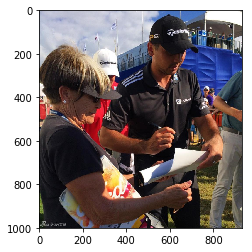

In [140]:
imgsequence = 5
cimage = cv.imread(datas[keyss[imgsequence]]['img_paths'])
plt.imshow(cimage[:, :, [2, 1, 0]])

In [142]:
cimage.shape

(1000, 932, 3)

In [143]:
datas[keyss[imgsequence]]['objpos']

[355, 643]

## Generate heatmap, pagmap and mask

In [144]:
meta = readmeta(datas[keyss[3]])
TransformMetaJoints(meta)

oriImg = cv.imread(meta['img_paths'])
maskmiss = getMask(meta)
maskmiss = maskmiss.astype(np.uint8)

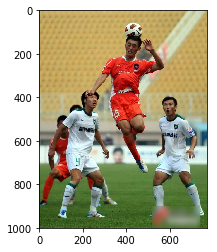

In [145]:
plt.imshow(oriImg[:, :, [2, 1, 0]])

In [146]:
newmeta, resizeImage, maskmiss_scale = augmentation_scale(meta, oriImg, maskmiss)

In [147]:
print newmeta['objpos']
print resizeImage.shape

[188.64359713356805, 187.87204867903404]
(386, 297, 3)


In [148]:
newmeta['joint_self']['joints']

[{'x': 130.00591458898248, 'y': 89.8853949532134},
 {'x': 109.55988054383093, 'y': 121.51888158910825},
 {'x': 98.37242795308764, 'y': 142.3506898615268},
 {'x': 184.78585486089796, 'y': 95.67200836221856},
 {'x': 212.5615992241227, 'y': 98.37242795308764},
 {'x': 199.05950126977734, 'y': 72.13978049893093},
 {'x': 140.03604449792476, 'y': 168.96911154295051},
 {'x': 156.23856204313918, 'y': 218.34821263312784},
 {'x': 176.29882186102373, 'y': 262.71224876883406},
 {'x': 164.7255950430134, 'y': 165.49714349754743},
 {'x': 177.07037031555774, 'y': 207.93230849691858},
 {'x': 161.63940122487733, 'y': 219.50553531492886},
 {'x': 167.04024040661548, 'y': 49.764875317444336},
 {'x': 158.93898163400826, 'y': 84.87032999874228}]

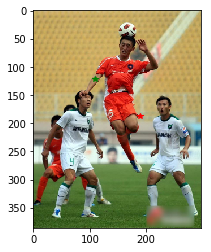

In [149]:
plt.imshow(resizeImage[:, :, [2, 1, 0]])
plt.plot(newmeta['objpos'][0], newmeta['objpos'][1], 'r*')
plt.plot(newmeta['joint_self']['joints'][1]['x'], newmeta['joint_self']['joints'][1]['y'], 'g*')

In [150]:
newmeta['joint_self']

{'isVisible': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'joints': [{'x': 130.00591458898248, 'y': 89.8853949532134},
  {'x': 109.55988054383093, 'y': 121.51888158910825},
  {'x': 98.37242795308764, 'y': 142.3506898615268},
  {'x': 184.78585486089796, 'y': 95.67200836221856},
  {'x': 212.5615992241227, 'y': 98.37242795308764},
  {'x': 199.05950126977734, 'y': 72.13978049893093},
  {'x': 140.03604449792476, 'y': 168.96911154295051},
  {'x': 156.23856204313918, 'y': 218.34821263312784},
  {'x': 176.29882186102373, 'y': 262.71224876883406},
  {'x': 164.7255950430134, 'y': 165.49714349754743},
  {'x': 177.07037031555774, 'y': 207.93230849691858},
  {'x': 161.63940122487733, 'y': 219.50553531492886},
  {'x': 167.04024040661548, 'y': 49.764875317444336},
  {'x': 158.93898163400826, 'y': 84.87032999874228}]}

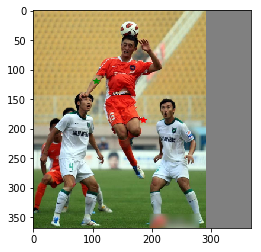

In [151]:
newmeta2, croppedImage, maskmiss_cropped = augmentation_croppad(newmeta, resizeImage,
                                                                   maskmiss_scale)
plt.imshow(croppedImage[:, :, [2, 1, 0]])
plt.plot(newmeta2['objpos'][0], newmeta2['objpos'][1], 'r*')
plt.plot(newmeta2['joint_self']['joints'][1]['x'], newmeta2['joint_self']['joints'][1]['y'], 'g*')

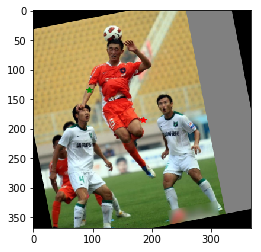

In [152]:
newmeta3, rotatedImage, maskmiss_rotate= augmentation_rotate(newmeta2, croppedImage, 
                                                             maskmiss_cropped)
plt.imshow(rotatedImage[:, :, [2, 1, 0]])
plt.plot(newmeta3['objpos'][0], newmeta3['objpos'][1], 'r*')
plt.plot(newmeta3['joint_self']['joints'][1]['x'], newmeta3['joint_self']['joints'][1]['y'], 'g*')

368


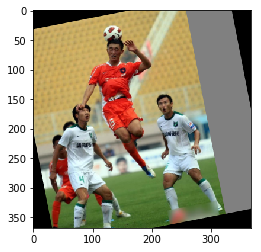

In [153]:
newmeta4, flipImage, maskmiss_flip = augmentation_flip(newmeta3, rotatedImage, maskmiss_rotate)
plt.imshow(flipImage[:, :, [2, 1, 0]])

In [154]:
newmeta4['objpos']

[184.64359713356805, 184.87204867903404]

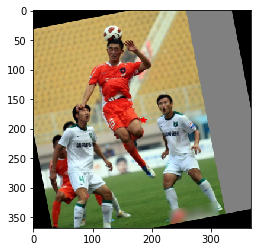

In [155]:
plt.imshow(flipImage[:, :, [2, 1, 0]])
plt.plot(newmeta4['objpos'][0], newmeta4['objpos'][1], 'r*')

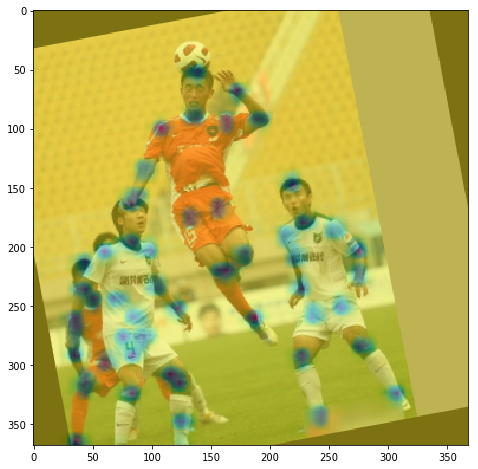

In [156]:
heatmap, pagmap = generateLabelMap(flipImage, newmeta4)
heatmapScale = cv.resize(heatmap[14], (0, 0), fx=8, fy=8)

f = plt.figure(1)
plt.imshow(flipImage[:,:,[2,1,0]])
ax2 = plt.imshow(heatmapScale, alpha=.5)
f.show()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 8)

In [157]:
image, mask, heatmap, pagmap = getImageandLabel(datas[keyss[imgsequence]])

368


1/右肩，2/右肘，3/右腕，4/左肩，5/左肘，6/左腕，7/右髋，8/右膝，9/右踝，10/左髋，11/左膝，12/左踝，13/头顶，14/脖子

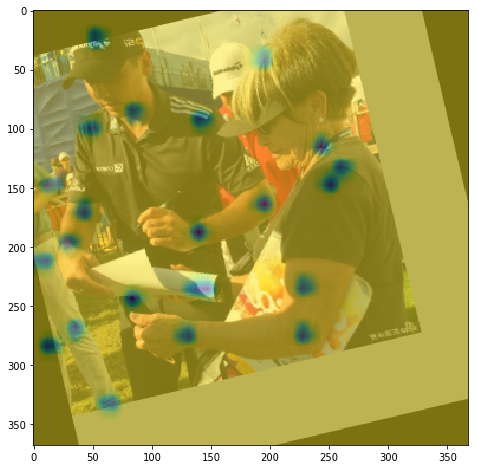

In [158]:
heatmapScale = cv.resize(heatmap[14], (0, 0), fx=8, fy=8)

f = plt.figure(1)
plt.imshow(image[:,:,[2,1,0]])
ax2 = plt.imshow(heatmapScale, alpha=.5)
f.show()
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 8)

In [159]:
heatmap[14].min()

0.00093778756669193886

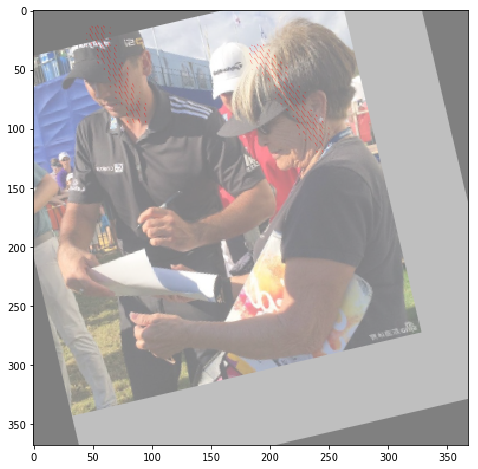

In [160]:
from numpy import ma

pagmapScale0 = cv.resize(pagmap[0], (0, 0), fx=8, fy=8)
pagmapScale1 = cv.resize(pagmap[1], (0, 0), fx=8, fy=8)
U = pagmapScale0 * -1
V = pagmapScale1
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.1*0.1] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

plt.figure()
plt.imshow(image[:,:,[2,1,0]], alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 8)

## mask

In [161]:
mask.min()

0

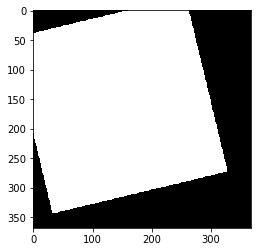

In [162]:
mask = mask*255
f = plt.figure(1)
plt.imshow(mask)

In [163]:
mask[50,50]

array([255, 255, 255], dtype=uint8)

In [164]:
mask[367,367]

array([0, 0, 0], dtype=uint8)